In [ ]:
import os
import json
from measures.utils import *
from measures.measures import *
import warnings
warnings.filterwarnings("ignore")

def generate_pies_res(path, n_initializations=30):
    n_ini = n_initializations-1
    dirs = []
    for file in os.listdir(path):
        d = os.path.join(path, file)
        if os.path.isdir(d):
            dirs.append(file)
    
    final_dirs = {}
    organized_results = {}
    for exp in dirs:
        if os.path.isfile(path+"/"+exp+"/"+str(n_ini)+"_measures.json"):
            f = open(path+"/"+exp+"/0_measures.json")
            data = json.load(f)

            dic_name = exp.split("_")[:3]
            dic_name = ("_").join(dic_name)
            if dic_name in final_dirs:
                final_dirs[dic_name].append((exp, len(data["accuracy"][0])-1))
                
            else:
                organized_results[dic_name]={}
                final_dirs[dic_name] = [(exp, len(data["accuracy"][0])-1)]
            f.close()
        
    for key in final_dirs:
        if True:
            multilabel = False
            if "Reuters" in key: 
                multilabel = True
                labels_n = 23
            elif "AAPD" in key:
                multilabel = True
                labels_n = 54
            elif "SNLI" in key:
                labels_n = 3
            elif "IMDB" in key:
                labels_n = 2
           
            num = 0

            for n in final_dirs[key]:
                if "NoPruning" in n[0]:
                    num=n[1]

            print("    No pruning")
            preds_dense =retrieve_predictions(path+"/"+key+"_NoPruning_0/","_epoch_"+str(num),n_initializations)
            if multilabel:
                preds_dense = apply_sig(preds_dense)


            for (name, num) in final_dirs[key]:
                print("    "+name)
                if "NoPruning" not in name and "random-WRs" not in name:

                    splitted_name = name.split("_")
                    algo = splitted_name[3]
                    if splitted_name[-2]=="ini":
                        algo+="_ini"
                    if algo not in organized_results[key]:
                        organized_results[key][algo] = {}

                    preds=retrieve_predictions(path+"/"+name+"/","_epoch_"+str(num),n_initializations)
                    
                    if multilabel:

                        ts = []
                        td = []

                        sparse = path+"/"+name+"/"
                        dense = path+"/"+key+"_NoPruning_0/"

                        preds = apply_sig(preds)


                        for i in range(n_initializations):
                            f = open(dense+str(i)+"_measures.json")
                            data = json.load(f)
                            td.append(data["threshold"][-1])

                            f = open(sparse+str(i)+"_measures.json")
                            data = json.load(f)
                            ts.append(data["threshold"][-1])

                        pies = retrieve_pies(preds_dense, preds, thresholds=(td, ts))

                        pies_ind = get_distinct_pies(pies)


                    else:

                        densep, sparsep = retrieve_preds(preds_dense, preds, labels_n)

                        pies = retrieve_pies(densep, sparsep, labels_n)
                        
                        pies_ind = np.where(pies)[0]



                    pruning_threshold = name.split("_")[-1]
                    organized_results[key][algo][pruning_threshold] = pies_ind
    return organized_results

results = generate_pies_res("./results/")



In [ ]:
r2 = results.copy()
print(results == r2)

True


In [ ]:
def clean_tuple(tup):
    tuple_to_list = []
    for el in tup:
        if type(el) == tuple:
            tuple_to_list.append(clean_tuple(el))
        else:
            if type(el) == np.ndarray:
                tuple_to_list.append(el.tolist())
            else:
                if type(el) == np.int32:
                    tuple_to_list.append(int(el))
                else:
                    tuple_to_list.append(float(el))
    
    return tuple_to_list


def clean_dic(dic):
    dic2 = {}
    for key, value in dic.items():
        if type(value) == dict:
            dic2[key] = clean_dic(value)
        else:
            if type(value) == tuple:
               dic2[key] = clean_tuple(value)
            elif type(value) == np.ndarray:
                dic2[key] = value.tolist()
            elif type(value) == list:
                dic2[key] = value
    return dic2
                
                

ex = clean_dic(results)

In [ ]:
out_file = open("path", "w")
import json
json.dump(ex, out_file, indent = 6)
  
out_file.close()

In [1]:
import json
f = open('path')
data_test = json.load(f)

In [2]:
import pandas as pd
df = pd.DataFrame.from_dict(data_test)


In [ ]:
import pandas as pd
import numpy as np

path_csv = 'path'



df = pd.read_csv(path_csv)
df = df[df["pruning algo"] != "random-WRs"]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df2 = df.groupby(['dataset',"model","pruning algo"]).agg({'0':['mean','std'], '20':['mean','std'],
                                                          '50':['mean','std'], '70':['mean','std'],
                                                          '90':['mean','std'], '99':['mean','std'],
                                                         'accuracy/f1':['mean','std']})
df2 = df2.reset_index()
tmp_dic = df2.to_dict()

tmp_res = {}
for i in range(len(tmp_dic[('pruning algo', '')])):
    if tmp_dic[('pruning algo', '')][i] == "NoPruning":
        tmp_res[(tmp_dic[('dataset', '')][i], tmp_dic[('model', '')][i], "mean")]=tmp_dic[('0',"mean")][i]
        tmp_res[(tmp_dic[('dataset', '')][i], tmp_dic[('model', '')][i], "std")]=tmp_dic[('0',"std")][i]



for i in range(len(tmp_dic[('pruning algo', '')])):
    tmp_dic[('0',"mean")][i] = round(tmp_res[(tmp_dic[('dataset', '')][i], tmp_dic[('model', '')][i], "mean")],3)
    tmp_dic[('0',"std")][i] = round(tmp_res[(tmp_dic[('dataset', '')][i], tmp_dic[('model', '')][i], "std")],3)

    for j in ['20','50','70','90','99']:
        tmp_dic[(j,"mean")][i] = round(tmp_dic[(j,"mean")][i],3)
        tmp_dic[(j,"std")][i] = round(tmp_dic[(j,"std")][i],3)

df2 = pd.DataFrame.from_dict(tmp_dic)

df_multiclass = df2[df2['dataset'] == "IMDB"]
df_multiclass2 = df2[df2['dataset'] == "SNLI"]
df_multiclass = pd.concat([df_multiclass, df_multiclass2])

df_multilabel = df2[df2['dataset'] == "Reuters"]
df_multilabel2 = df2[df2['dataset'] == "AAPD"]
df_multilabel = pd.concat([df_multilabel, df_multilabel2])


df_multilabel = df_multilabel.drop(df_multilabel[df_multilabel["pruning algo"] == "NoPruning"].index).drop(columns=['accuracy/f1'])
df_multilabel = df_multilabel.set_index(["dataset","model","pruning algo"])

df_multiclass = df_multiclass.drop(df_multiclass[df_multiclass["pruning algo"] == "NoPruning"].index).drop(columns=['accuracy/f1'])
df_multiclass = df_multiclass.set_index(["dataset","model","pruning algo"])

dic_ml = df_multilabel.to_dict()
print(dic_ml)

dic_mc = df_multiclass.to_dict()
print(dic_mc)

def convert_names(df):
    return df.reset_index().replace({
    "IBP-WRs":"IIBP-WR",
    "IBPs":"IIBP",
    "IBPs_ini":"IBP-AI",

    "IMP-WRs":"IMP-WR",
    "IMPs":"IMP",
    "IMPs_ini":"MP-AI",

    "randoms":"IRP",
    "randoms_ini":"RP-AI"
    }).set_index(["dataset","model","pruning algorithm"])

def three_decimals(x):
    return '{0:.3f}'.format(x)

def color_df_double(df, df2):
    dic_f = {}
    
    df_final = df.copy().astype({'20': 'str','50': 'str','70': 'str','90': 'str','99': 'str'}) 


    for t in ['20','50','70','90','99']:
        if t not in dic_f:
            dic_f[t]={}

        datasets = list(set([x[0] for x in df[t].index]))
        for dataset in datasets:
            if dataset not in dic_f[t]:
                dic_f[t][dataset]={}

            dic_to = dic_ml
            if dataset in ["IMDB", "SNLI"]:
                dic_to = dic_mc
            for model in ["BERT","BiLSTM"]:
                if model not in dic_f[t][dataset]:
                    dic_f[t][dataset][model]={}

                for algo in (df[t][dataset][model].index):
                    if algo not in dic_f[t][dataset][model]:
                        dic_f[t][dataset][model][algo]=[(dic_to[t,'mean'][(dataset, model, algo)],  df[t][dataset][model][algo]), 
                                                        (dic_to['0','mean'][(dataset, model, algo)],  df2[t][dataset][model][algo])]
                                                        
                    
                    tmp_str = three_decimals(round( dic_to['0','mean'][(dataset, model, algo)] -  df2[t][dataset][model][algo],3))
                    df_final[t][dataset][model][algo] = three_decimals(round( dic_to[t,'mean'][(dataset, model, algo)] -  df[t][dataset][model][algo],3))+" "+tmp_str


    df_final = convert_names(df_final)
    return df_final, dic_f


def tab_dic_to_pd_double(tab_dic1, tab_dic2):
    df = pd.DataFrame.from_dict(tab_dic1)
    df = df.groupby(['dataset',"model","pruning algorithm"]).mean()
    df = df.reset_index()
    df = df.set_index(["dataset","model","pruning algorithm"])

    df2 = pd.DataFrame.from_dict(tab_dic2)
    df2 = df2.groupby(['dataset',"model","pruning algorithm"]).mean()
    df2 = df2.reset_index()
    df2 = df2.set_index(["dataset","model","pruning algorithm"])

    return color_df_double(df, df2)



In [4]:
# indexces ref: 0 Class distribution, 1 (num pies, percentage pies),2 accuracy dense, 3 accuracy sparse

def generate_table_dic(dic, t_num):
    table_template1={"model":[],"dataset":[],"pruning algorithm":[],"20":[],"50":[],"70":[],"90":[],"99":[]}
    table_template2={"model":[],"dataset":[],"pruning algorithm":[],"20":[],"50":[],"70":[],"90":[],"99":[]}

    tmp_keys = dic.keys()
    keys = [k for k in tmp_keys if "IMDB" in k] + [k for k in tmp_keys if "SNLI" in k] + [k for k in tmp_keys if "Reuters" in k] + [k for k in tmp_keys if "AAPD" in k]
    for key in keys:
        tmp = key.split("_")

        dataset = tmp[0]
        model = tmp[-1]

        for algo, thresholds in dic[key].items():
            for threshold, res in thresholds.items():
                if "orig" not in str(threshold):

                    val = None

                    if t_num == 0:
                        val = res[1][1]
                    elif t_num == 1:
                        val = res[3] - res[2]
                    elif t_num ==2:
                        val = res[2]
                    elif t_num == 3:
                        val = res[3]
                    
                    templ = table_template2
                    if dataset=="IMDB" or dataset=="SNLI":
                        templ = table_template1
                    
                    templ["dataset"].append(dataset)
                    templ["model"].append(model)
                    templ["pruning algorithm"].append(algo)

                    for i in ["20","50","70","90","99"]:
                        templ[i].append(None)
                    templ[threshold][-1]=val


    return table_template1, table_template2

In [5]:
import pandas as pd
tab_dic_mc_a, tab_dic_ml_a = generate_table_dic(data_test,3)

tab_dic_mc_d, tab_dic_ml_d = generate_table_dic(data_test,2)

In [ ]:
df_final_mc = tab_dic_to_pd_double(tab_dic_mc_a,tab_dic_mc_d)
df_final_ml = tab_dic_to_pd_double(tab_dic_ml_a,tab_dic_ml_d)
df_final_mc[1]

dict_keys(['Reuters', 'AAPD'])


C:\Users\pzs162\AppData\Local\Temp\ipykernel_22744\1912646794.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


dict_keys(['IMDB', 'SNLI'])


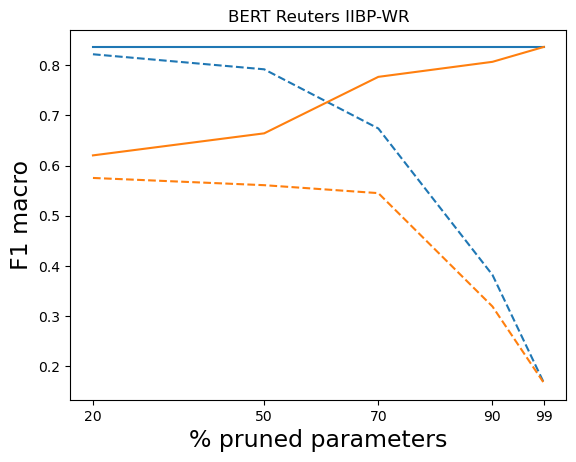

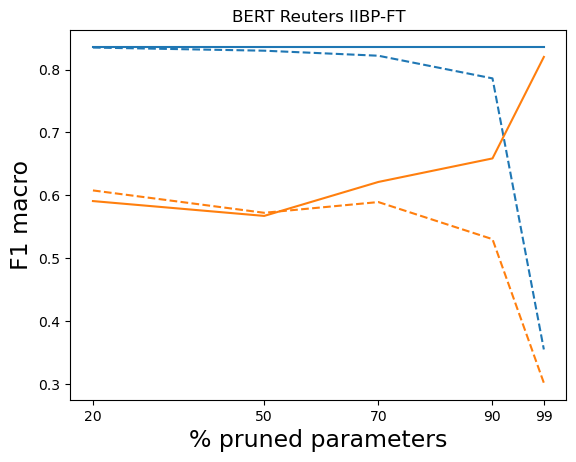

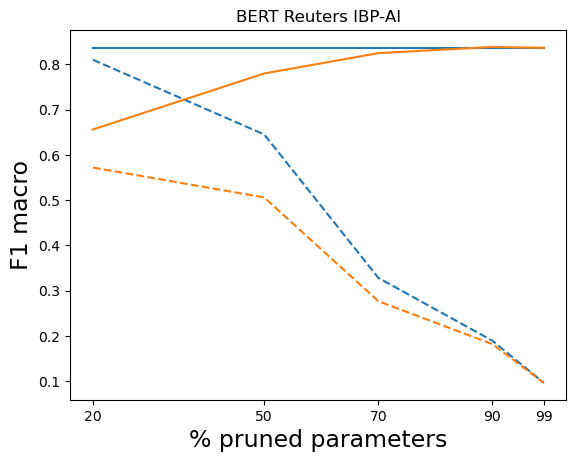

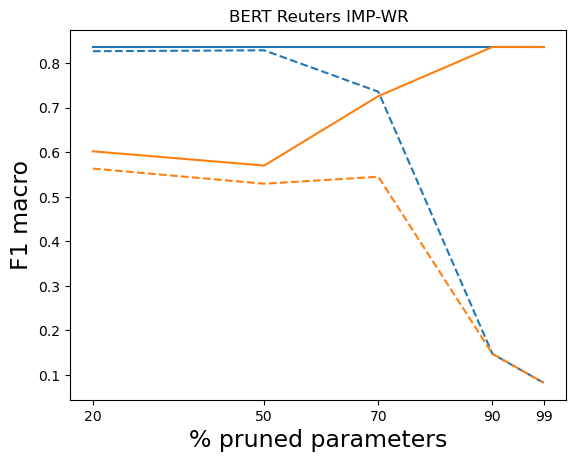

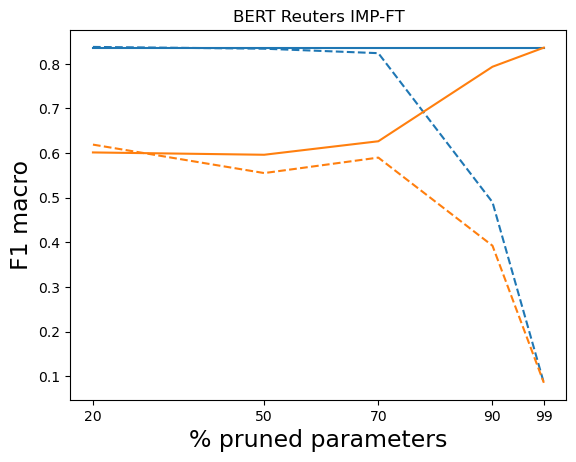

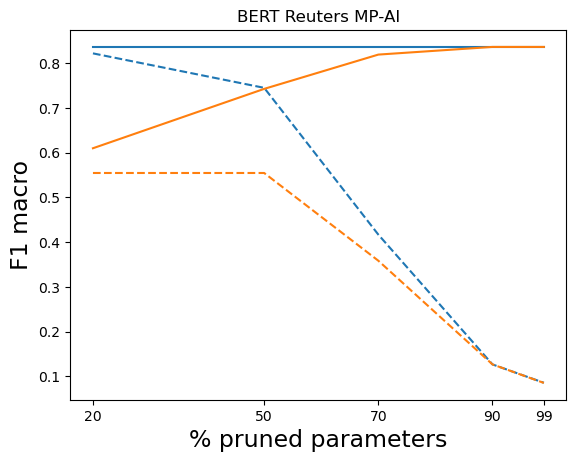

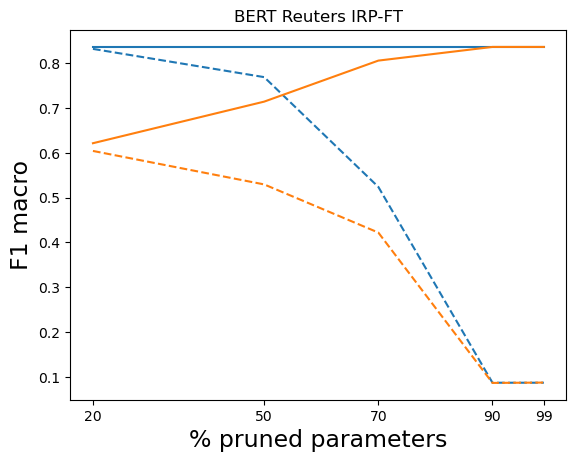

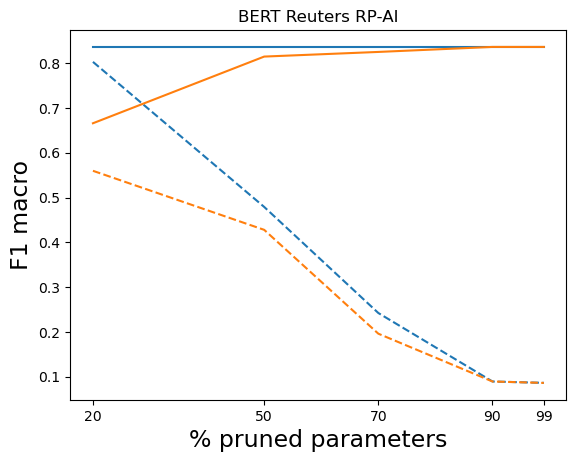

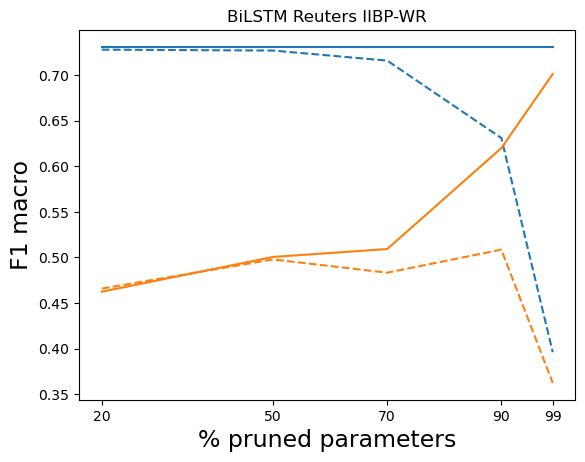

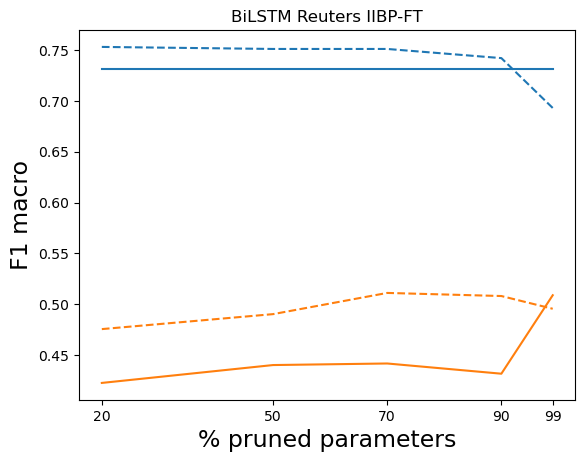

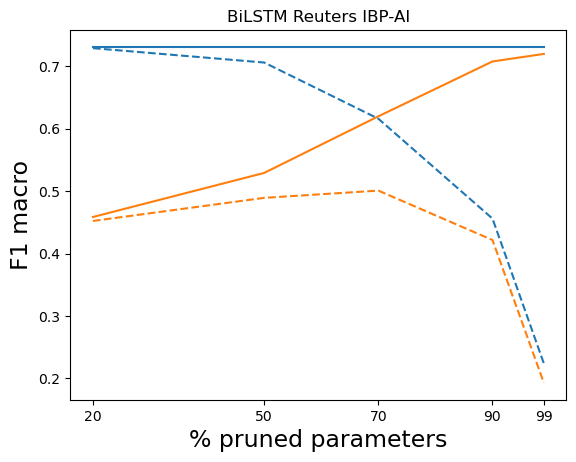

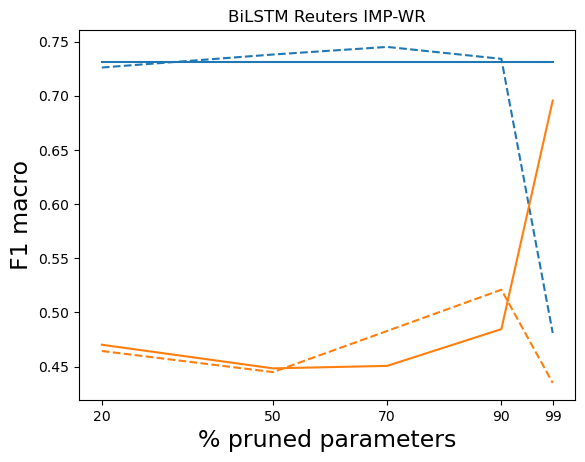

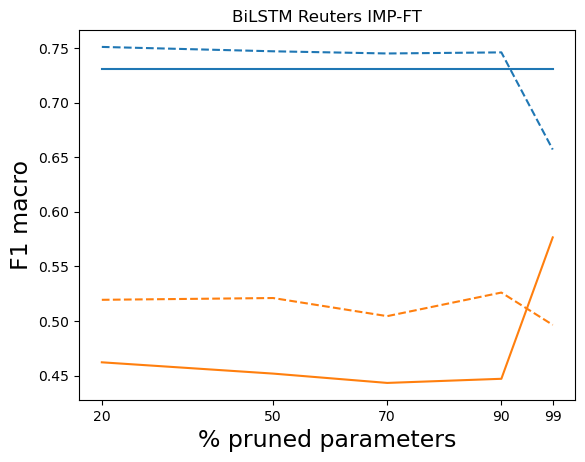

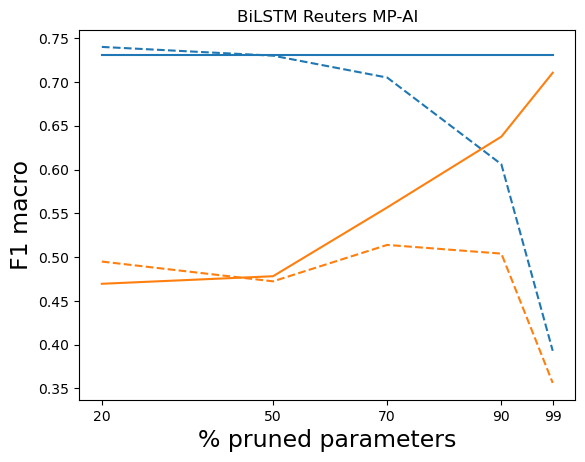

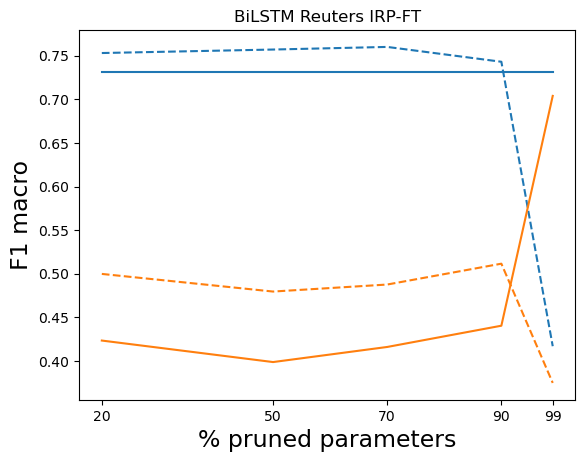

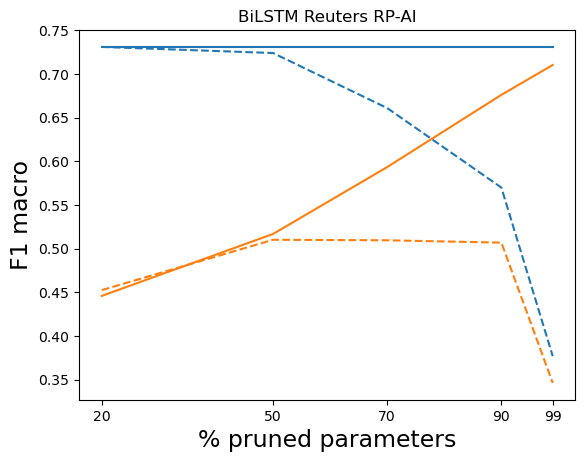

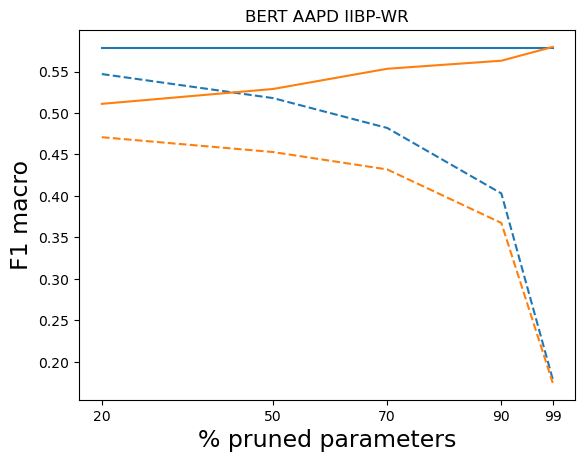

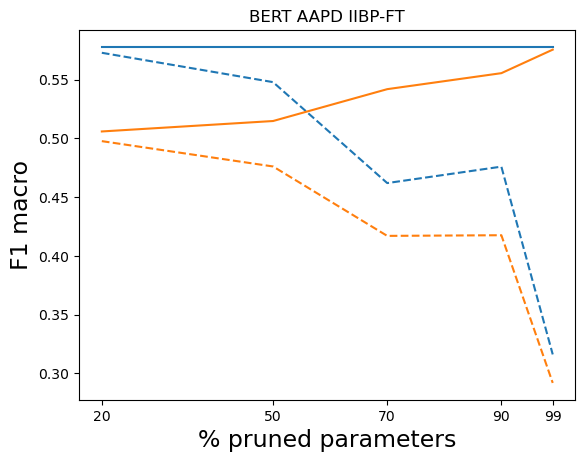

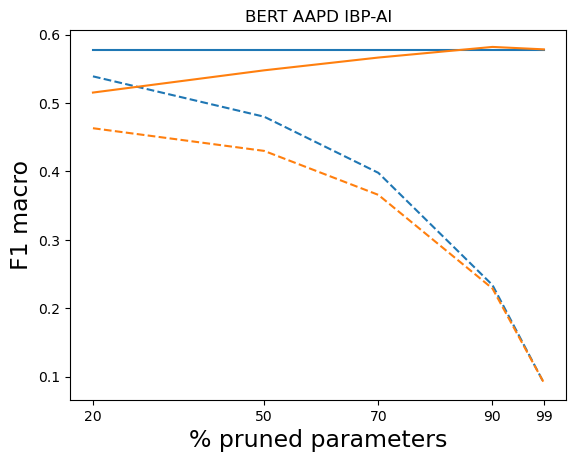

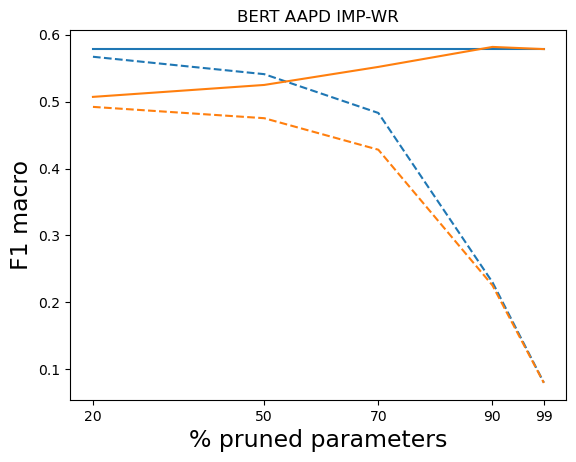

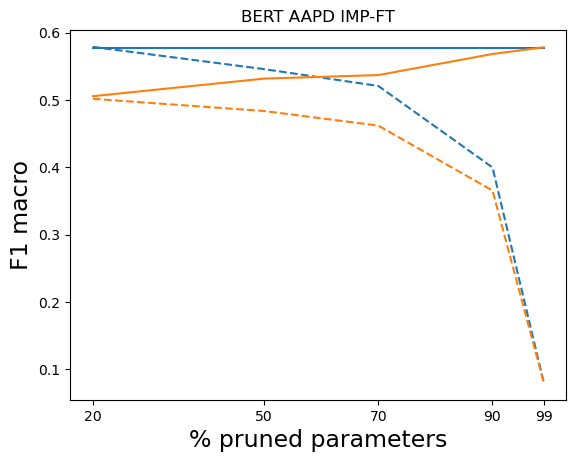

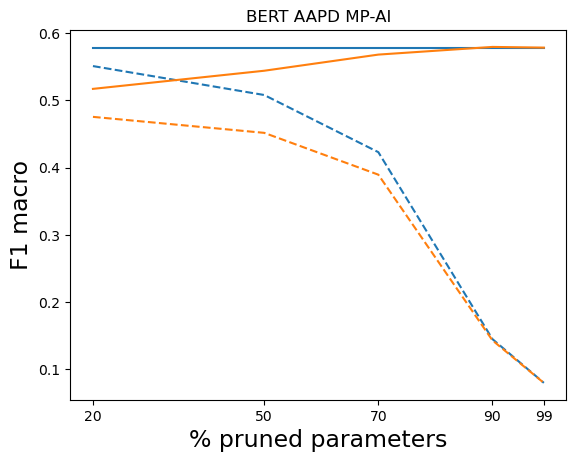

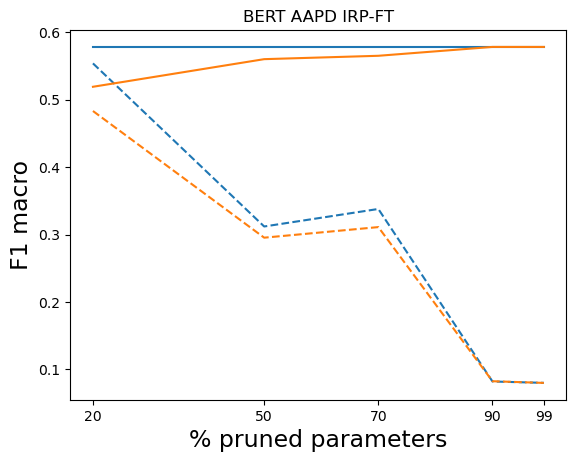

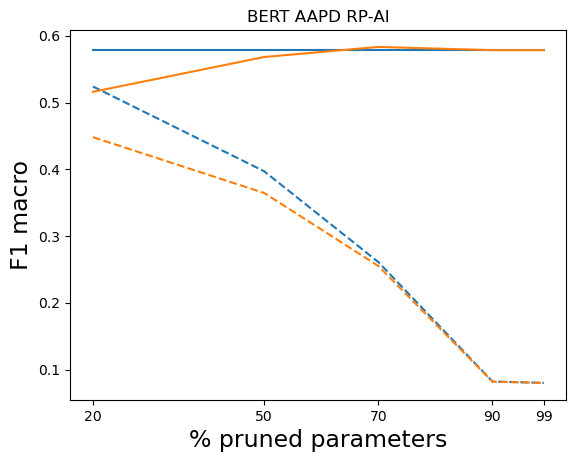

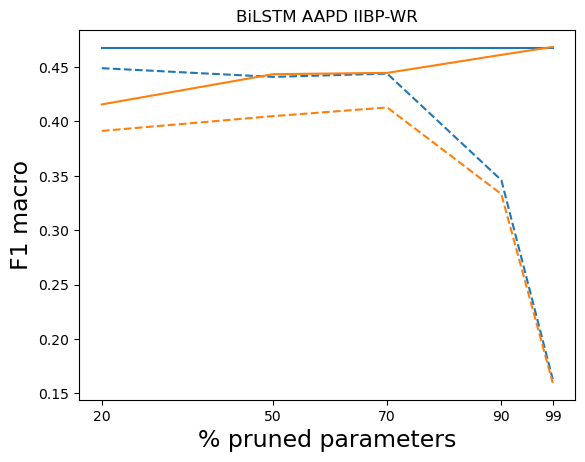

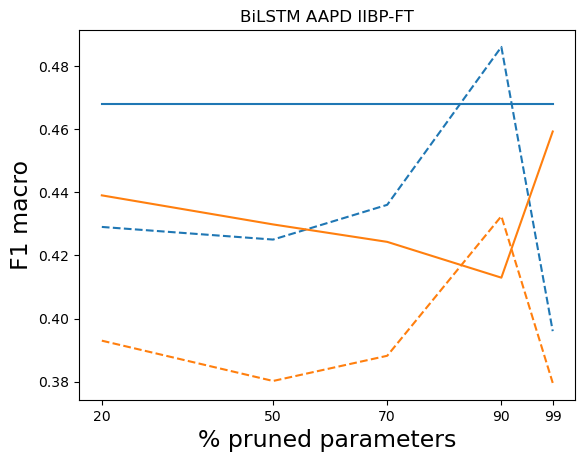

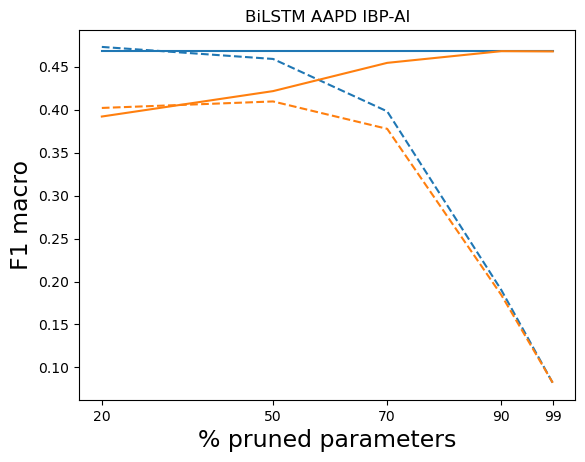

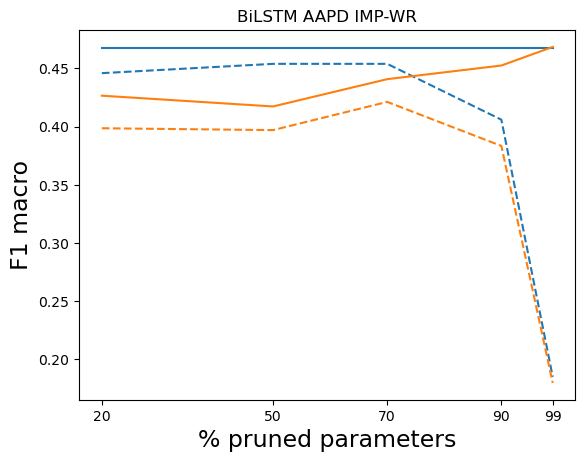

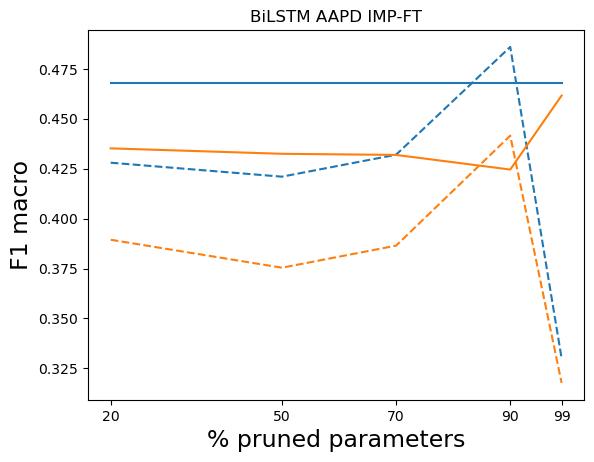

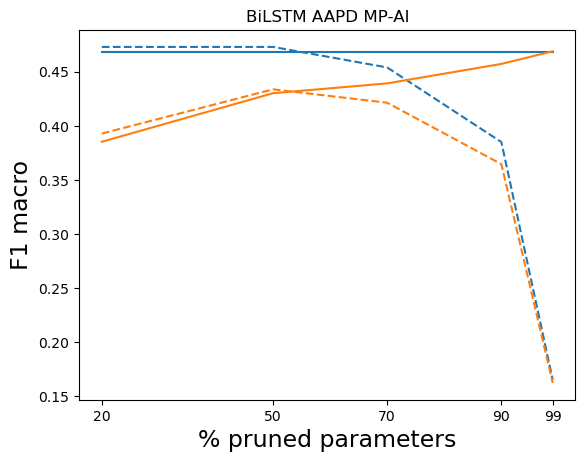

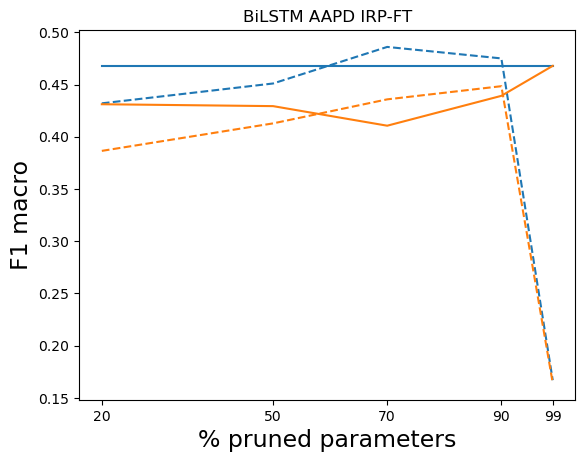

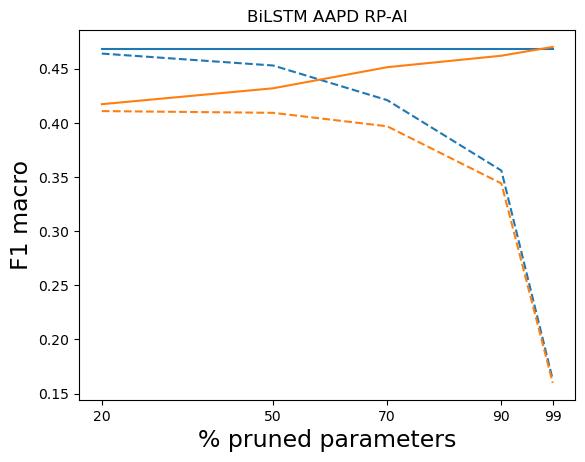

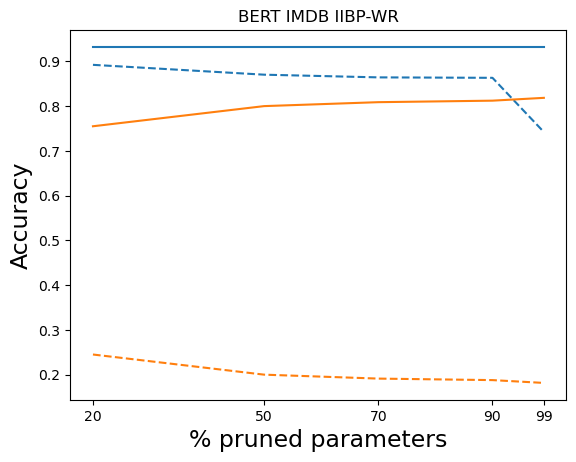

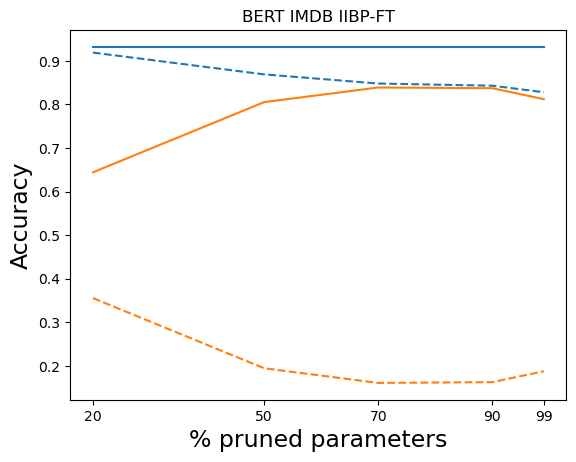

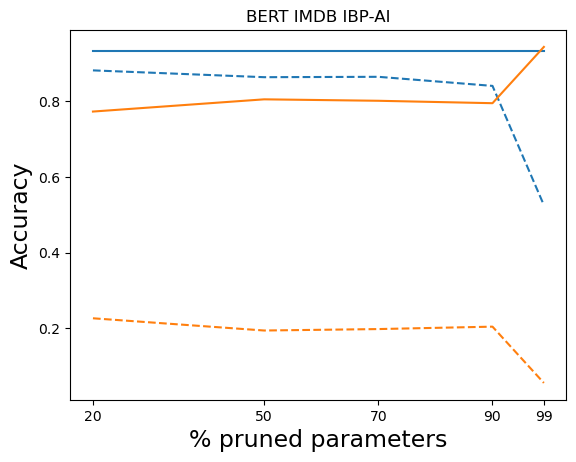

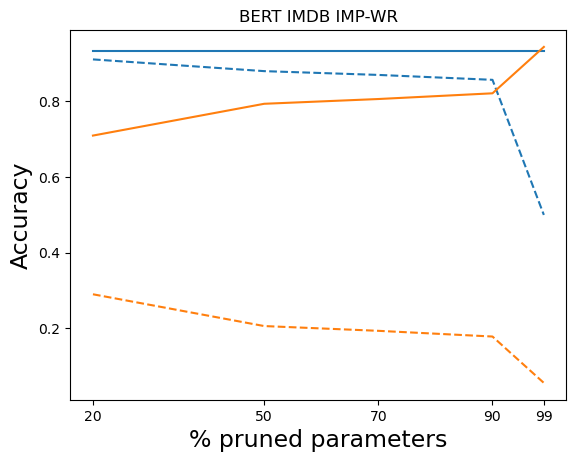

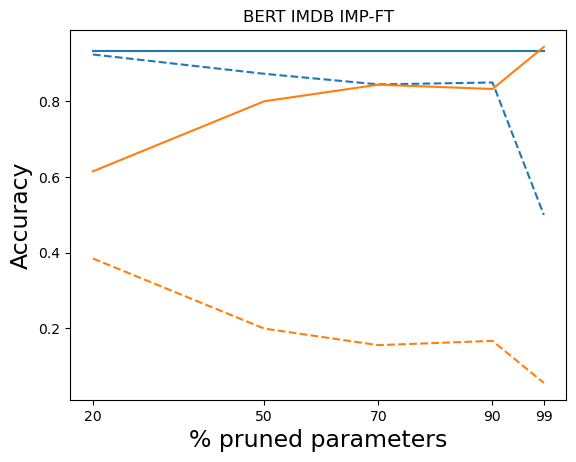

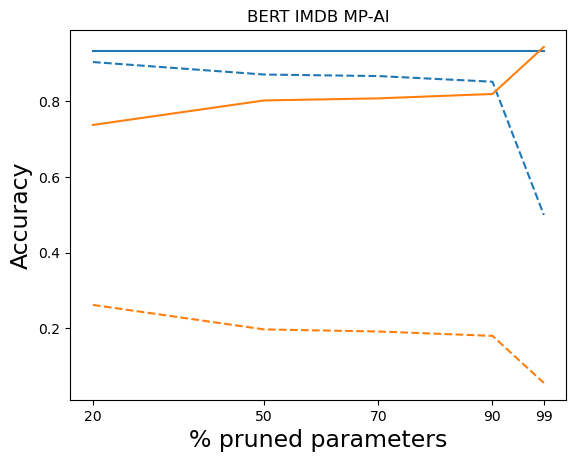

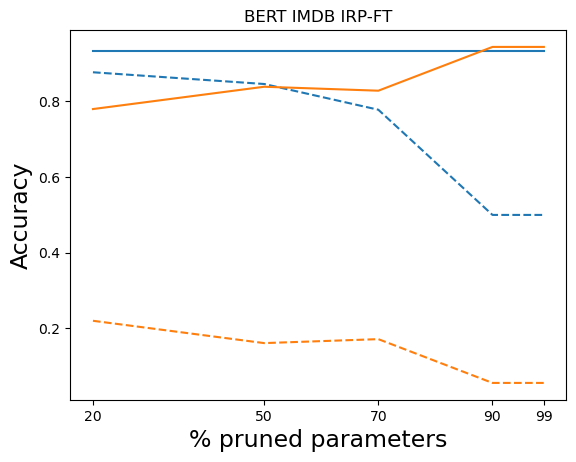

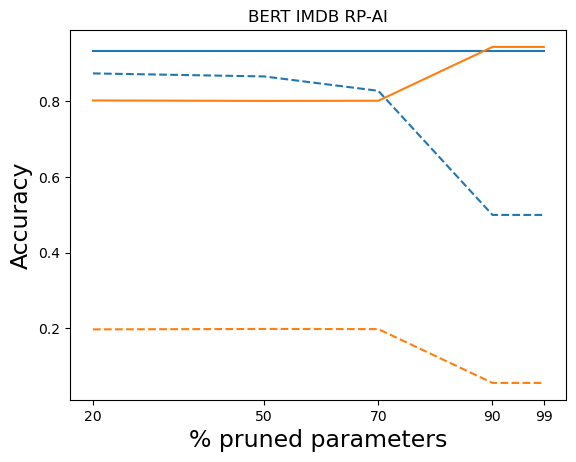

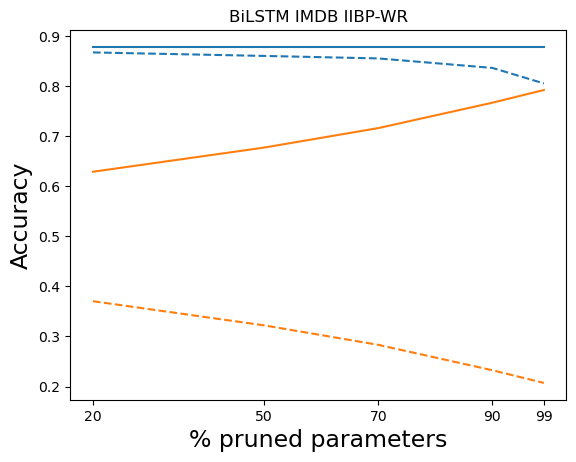

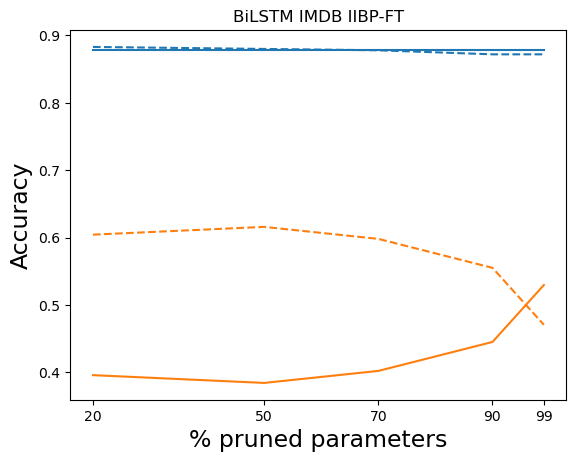

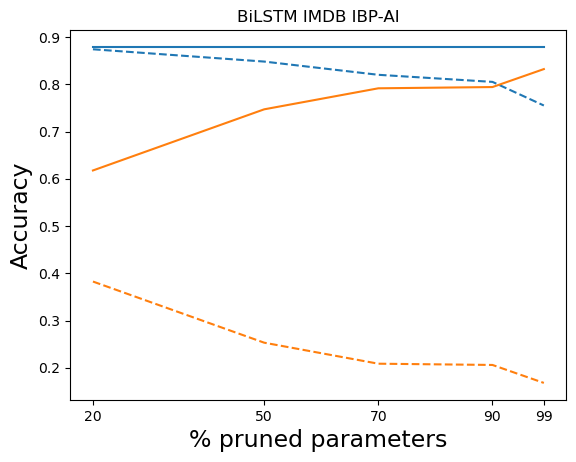

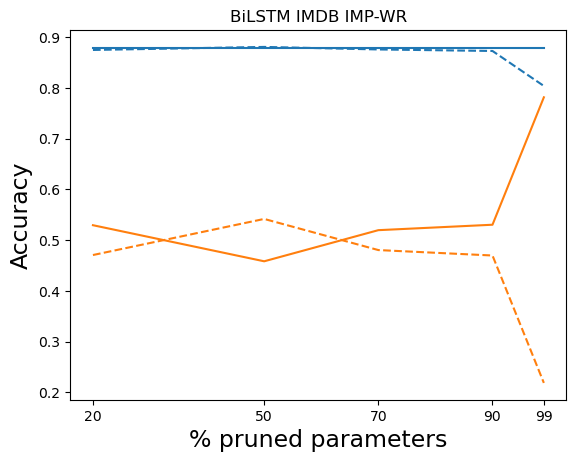

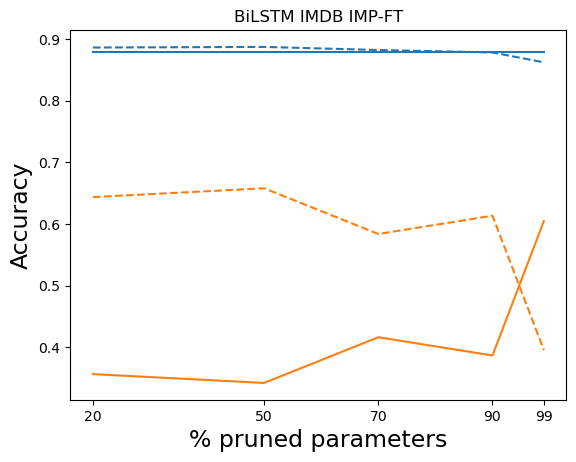

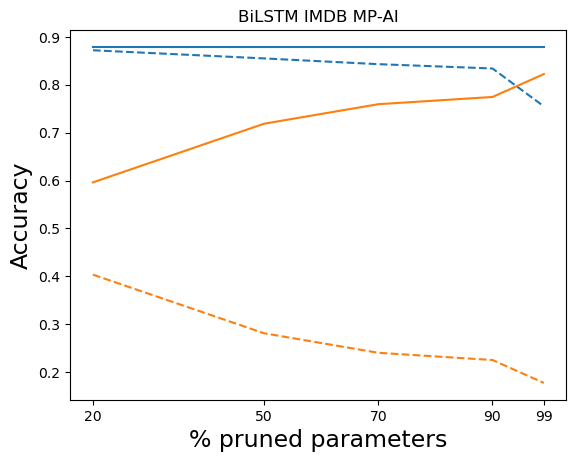

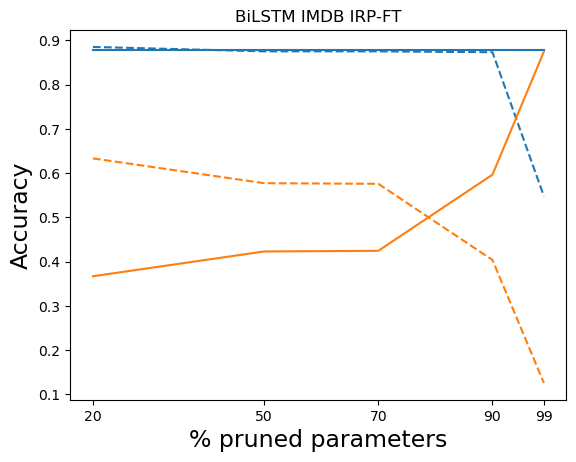

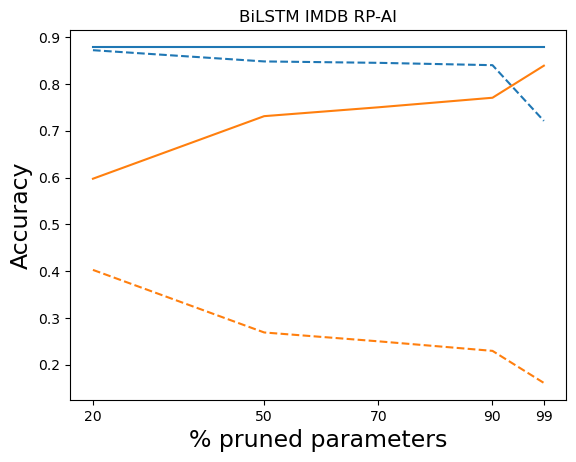

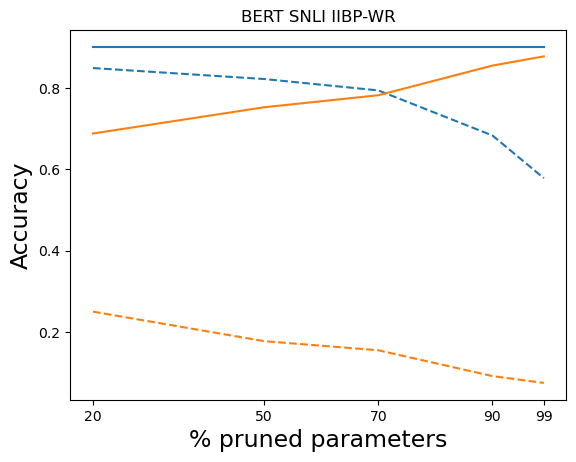

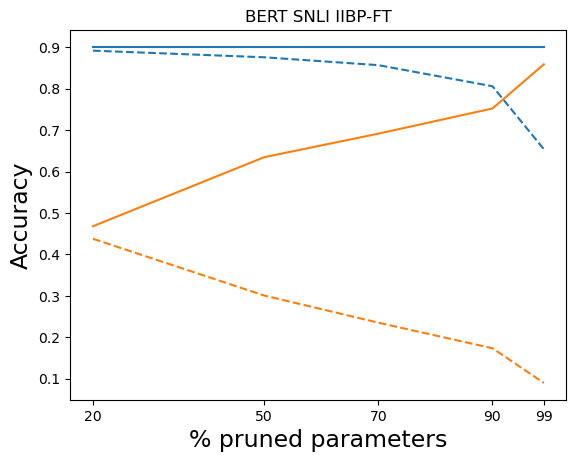

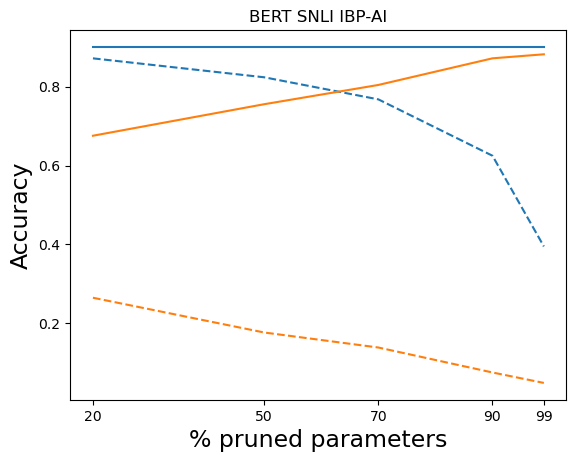

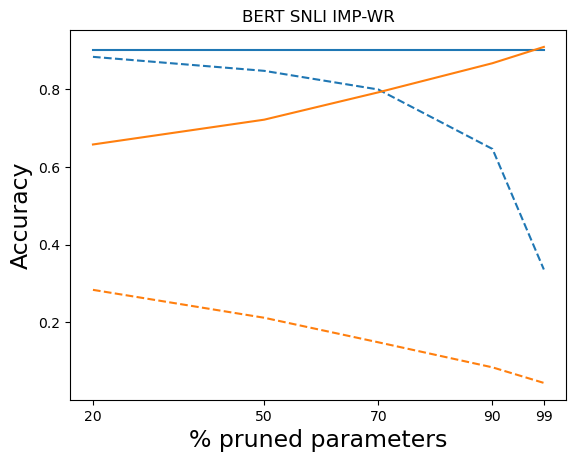

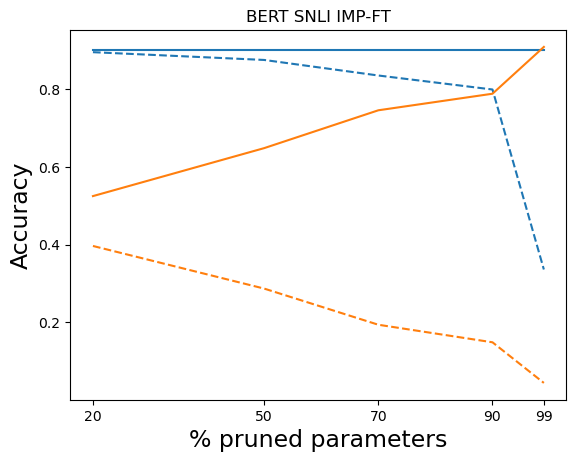

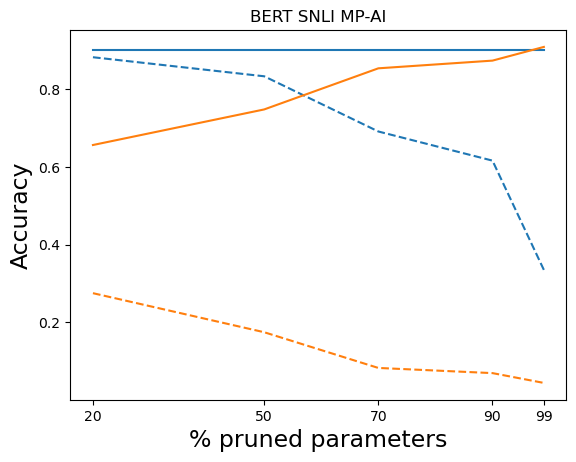

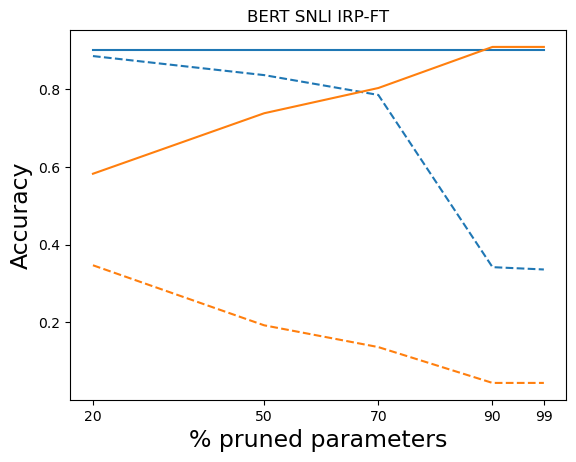

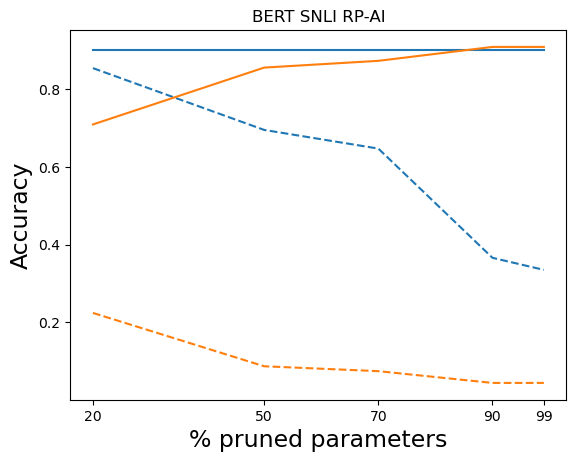

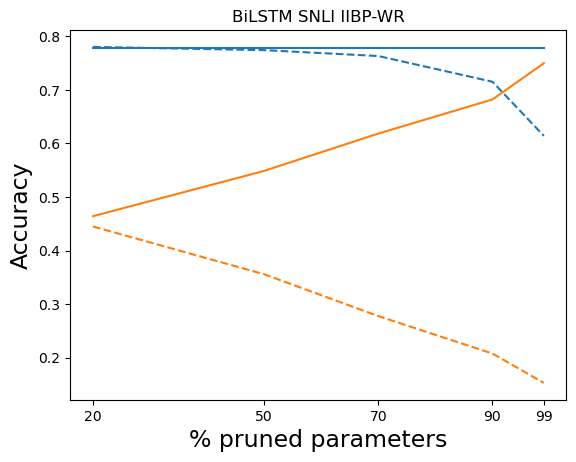

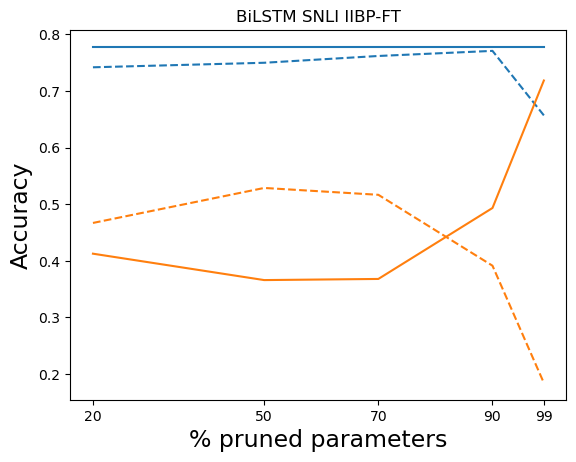

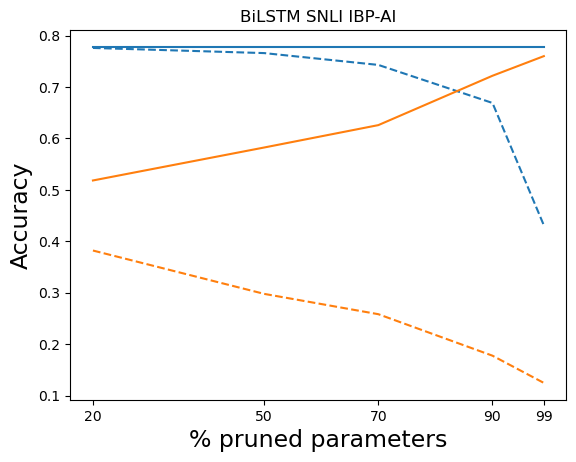

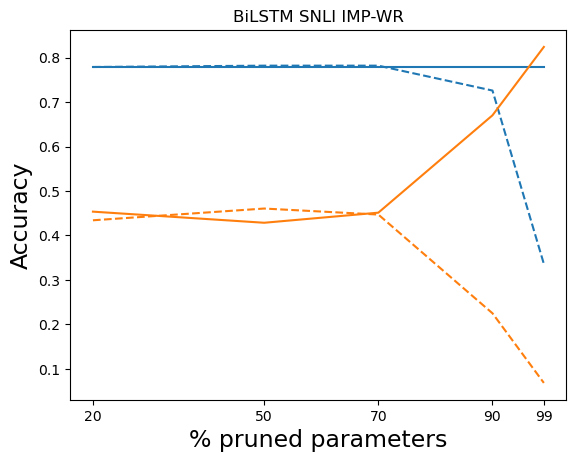

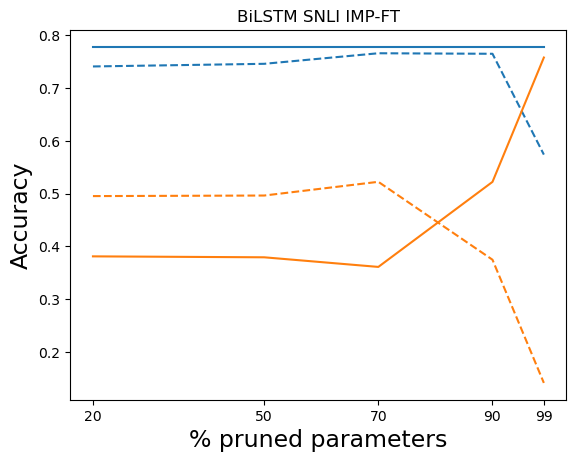

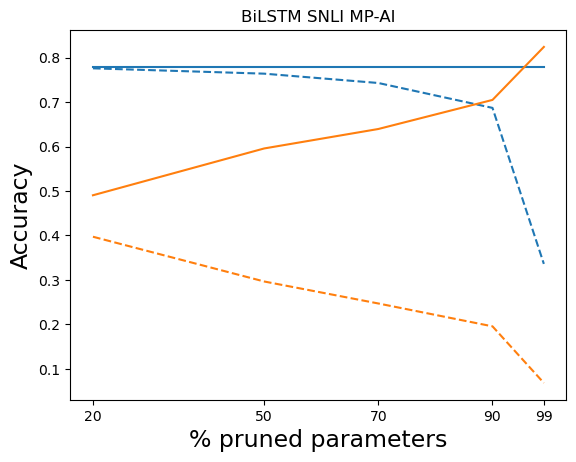

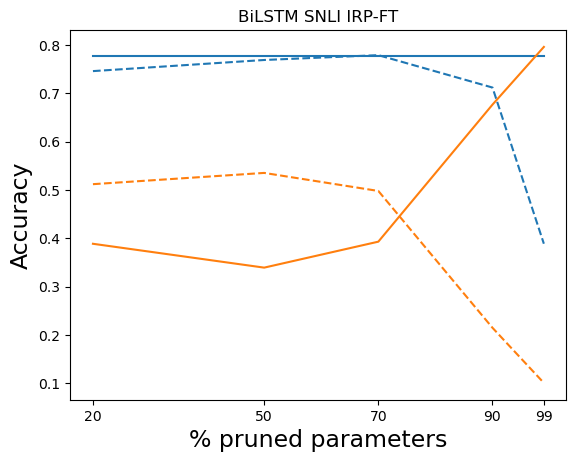

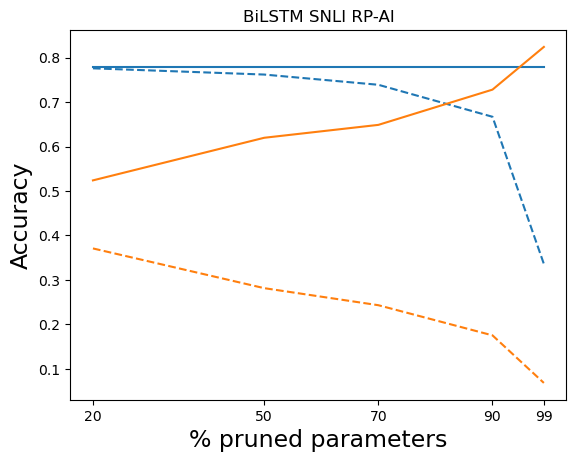

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


old_names_to_new = {
    "IBPs_ini":"IBP-AI",
    "IMPs_ini":"MP-AI",
    "randoms_ini":"RP-AI",

    "IBP-WRs":"IIBP-WR",
    "IBPs":"IIBP-FT",
    

    "IMP-WRs":"IMP-WR",
    "IMPs":"IMP-FT",
    

    "randoms":"IRP-FT"
    
}

for dic_f in [df_final_ml[1], df_final_mc[1]]:

    x_axis = [20, 50, 70, 90, 99]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors_l = prop_cycle.by_key()['color']

    print(dic_f["20"].keys())

    for dataset in dic_f["20"].keys():
        for architecture in dic_f["20"][dataset].keys():
            for algo in dic_f["20"][dataset][architecture].keys():
                eff_all_pruned = []
                eff_pies_pruned = []

                eff_all_unpruned = []
                eff_pies_unpruned = []

                for t in dic_f.keys():

                    eff_all_pruned.append(dic_f[t][dataset][architecture][algo][0][0])
                    eff_pies_pruned.append(dic_f[t][dataset][architecture][algo][0][1])

                    eff_all_unpruned.append(dic_f[t][dataset][architecture][algo][1][0])
                    eff_pies_unpruned.append(dic_f[t][dataset][architecture][algo][1][1])
                

                plt.title(architecture+" "+dataset+" "+old_names_to_new[algo])
                name=architecture+"_"+dataset+" "+algo
                plt.plot(x_axis, eff_all_pruned, "--", color=colors_l[0])
                plt.plot(x_axis, eff_pies_pruned, "--", color=colors_l[1])

                plt.xlabel("% pruned parameters", fontsize=17)
                plt.ylabel("F1 macro", fontsize=17)
                if dataset in ["SNLI", "IMDB"]:
                    plt.ylabel("Accuracy", fontsize=17)

                plt.plot(x_axis, eff_all_unpruned, color=colors_l[0])
                plt.plot(x_axis, eff_pies_unpruned, color=colors_l[1])

                plt.xticks(x_axis)

                plt.savefig('path'+name+'.pdf', dpi=400, transparent=True, bbox_inches='tight')
                plt.figure()
                
            
        
    

            



In [3]:
# indexces ref: 0 Class distribution, 1 (num pies, percentage pies),2 accuracy dense, 3 accuracy sparse

def generate_table_dic(dic, t_num):
    table_template1={"model":[],"dataset":[],"pruning algorithm":[],"20":[],"50":[],"70":[],"90":[],"99":[]}
    table_template2={"model":[],"dataset":[],"pruning algorithm":[],"20":[],"50":[],"70":[],"90":[],"99":[]}

    tmp_keys = dic.keys()
    keys = [k for k in tmp_keys if "IMDB" in k] + [k for k in tmp_keys if "SNLI" in k] + [k for k in tmp_keys if "Reuters" in k] + [k for k in tmp_keys if "AAPD" in k]
    for key in keys:
        tmp = key.split("_")

        dataset = tmp[0]
        model = tmp[-1]

        for algo, thresholds in dic[key].items():
            for threshold, res in thresholds.items():
                if "orig" not in str(threshold):

                    val = None

                    if t_num == 0:
                        val = res[1][1]
                    elif t_num == 1:
                        val = res[3] - res[2]
                    elif t_num ==2:
                        val = res[2]
                    elif t_num == 3:
                        val = res[3]
                    
                    templ = table_template2
                    if dataset=="IMDB" or dataset=="SNLI":
                        templ = table_template1
                    
                    templ["dataset"].append(dataset)
                    templ["model"].append(model)
                    templ["pruning algorithm"].append(algo)

                    for i in ["20","50","70","90","99"]:
                        templ[i].append(None)
                    templ[threshold][-1]=val


    return table_template1, table_template2

In [ ]:
import json
import pandas as pd
import numpy as np

f = open('path')
data_test = json.load(f)

datasets = ["IMDB", "SNLI", "Reuters", "AAPD"]
architectures = ["BiLSTM", "BERT"]

res = {}

for dataset in datasets:
    res[dataset]={}
    for architecture in architectures:
        res[dataset][architecture]={}

        path_csv = './data/stats/'+dataset+'_'+architecture+'.csv'
        df = pd.read_csv(path_csv)

        

        for algo in data_test[dataset+"_0_"+architecture]:
            res[dataset][architecture][algo] = {}
            for thres in data_test[dataset+"_0_"+architecture][algo]:
                res[dataset][architecture][algo][thres]={}

                df2 = df.copy()
                tmp = np.zeros(len(df2))

                tmp[data_test[dataset+"_0_"+architecture][algo][thres]]=1
                df2["PIE"] = tmp

                df2 = df2.groupby(["PIE"]).mean()

                not_pie_res, pie_res, all_res = None, None, None

                if sum(tmp) < len(tmp):
                    not_pie_res = df2.loc[0.0].tolist()
                
                if sum(tmp) != 0:
                    pie_res = df2.loc[1.0].tolist()

                

                df2 = df.copy()
                tmp = np.zeros(len(df2))
                df2["PIE"] = tmp
                df2 = df2.groupby(["PIE"]).mean()

                all_res = df2.loc[0.0].tolist()             

                
                res[dataset][architecture][algo][thres]["all"]=all_res

                res[dataset][architecture][algo][thres]["pies"]=pie_res
                res[dataset][architecture][algo][thres]["not_pies"]=not_pie_res

print(res)

In [2]:
import json
import pandas as pd

f = open('path')
data_test = json.load(f)

path_csv = './data/stats/Reuters_BiLSTM.csv'
df = pd.read_csv(path_csv)

names_m = list(df.columns)

In [ ]:
print(names_m)
print(len(names_m))

In [ ]:
import matplotlib.pyplot as plt
from measures.utils import *
from measures.measures import *
import os

names = []
def get_images(res, ms):
    thresholds = [20,50,70,90,99]
    for dataset in res:
        for architecture in res[dataset]:
            for algo in res[dataset][architecture]:
                values_pies = []
                values_not_pies = []
                for thres in thresholds:
                    values_pies.append(res[dataset][architecture][algo][str(thres)]["pies"])
                    values_not_pies.append(res[dataset][architecture][algo][str(thres)]["not_pies"])

                values_pies = np.array(values_pies)
                values_not_pies = np.array(values_not_pies)

                for m in ms:
                    y_name = names_m[m]
                    if names_m[m] == "length":
                        n = "./"+names_m[m]
                        if not os.path.isdir(n):
                            os.makedirs(n)

                        tmp = names_m[m]+"/"+dataset+"_"+architecture+"_"+algo

                        y_name = "% words"
                        plot_data([thresholds,thresholds], [values_pies[:,m], values_not_pies[:,m]], title=algo, xlabel="% pruned parameters", ylabel=y_name, legend=["PIEs","Not PIEs"], name="./Images/anal3/"+tmp+".png", xticks=[20,50,70,90,99])


get_images(res,[i for i in range(1,len(names_m))])

In [ ]:
import matplotlib.pyplot as plt
from measures.utils import *
from measures.measures import *
import os


def convert_names(legend):
    converter = {
    "IBP-WRs":"IIBP-WR",
    "IBPs":"IIBP",
    "IBPs_ini":"IBP-AI",

    "IMP-WRs":"IMP-WR",
    "IMPs":"IMP",
    "IMPs_ini":"MP-AI",

    "randoms":"IRP",
    "randoms_ini":"RP-AI"
    }

    new_legend = []

    for name in legend:
        new_legend.append(converter[name])
    return new_legend


names = []
def get_images(res, ms):
    thresholds = [20,50,70,90,99]
    for dataset in res:
        print()
        print(dataset)
        for architecture in res[dataset]:
            print(architecture)
            for m in ms:
                y_name = names_m[m]
                if names_m[m] == "length":
                    y_name = "Tokens ratio"

                legend = []

                to_show = []
                x_ax = []

                n = "./Images/anal3/"+names_m[m]
                if not os.path.isdir(n):
                    os.makedirs(n)
                
                style=[]

                aggregated = np.array([.0 for _ in range(5)])
            

                for algo in res[dataset][architecture]:
                    legend.append(algo)
                    tmp_to_show = []
                    x_tmp = []

                    for thres in thresholds:
                        if res[dataset][architecture][algo][str(thres)]["pies"] is not None and res[dataset][architecture][algo][str(thres)]["all"] is not None:
                            tmp_to_show.append(res[dataset][architecture][algo][str(thres)]["pies"][m]/(res[dataset][architecture][algo][str(thres)]["all"][m]+1e-10))
                            x_tmp.append(thres)
                    
                    x_ax.append(x_tmp)
                    to_show.append(tmp_to_show)
                    aggregated+=np.array(tmp_to_show)

                    style.append('--')
                
                # Straight line
                x_ax.append(x_tmp)
                to_show.append([1,1,1,1,1])
                style.append('-')

                # Aggregated
                x_ax.append(x_tmp)
                to_show.append(aggregated/(len(res[dataset][architecture])))
                to_show = np.array(to_show)
                style.append('-')


                tmp = names_m[m]+"/"+dataset+"_"+architecture
                final_legend = legend=convert_names(legend)
                print()
                print(final_legend)
                print()

                xl =""
                if y_name=="Tokens ratio" or y_name=="gunning_fog":
                    xl="% pruned parameters"
                
                the_title = y_name.replace("_"," ").upper()
                if "AUTOMATED" in the_title:
                    the_title+= " (a)"
                if "COLEMAN" in the_title:
                    the_title+= " (b)"
                if "FLESCH" in the_title:
                    the_title+= " (c)"
                if "LINSEAR" in the_title:
                    the_title+= " (d)"
                if "DALE" in the_title:
                    the_title+= " (e)"
                if "DIFFICULT" in the_title:
                    the_title+= " (f)"
                if "GUNNING" in the_title:
                    the_title+= " (g)"
                if "TOKENS" in the_title:
                    the_title+= " (h)"
                
                plot_data_tokens(x_ax, to_show, title=the_title, style=style, xlabel=xl,  ylabel="", name="./Images/anal3/"+tmp+".pdf", xticks=[20,50,70,90,99])



get_images(res,[i for i in range(1,len(names_m))])

In [ ]:
import json
import pandas as pd
import numpy as np
from datasets_folder.dataset import *

f = open('path')
data_test = json.load(f)

datasets = ["Reuters", "AAPD"]
architectures = ["BiLSTM", "BERT"]

res = {}

for dataset in datasets:

    print("starting: "+dataset)
    key = dataset
    if "IMDB" in key:
        labels_n = [("pos",1),("neg",0)]
        training_set = DatasetIMDB2("", labels_n, setting="BiLSTM")
        training_set.load_set("test", vec_max_len=512)

    elif "SNLI" in key:
        labels_n = [("entailment",0),("neutral",1),("contradiction",2)]
        training_set = DatasetNLI2("", labels_n, setting="BiLSTM")
        training_set.load_set("test", vec_max_len=128)
    elif "Reuters" in key:
        multilabel=True
        lines = []
        with open('data/Reuters/reuters_labels.txt') as f:
            lines = f.read().splitlines()
        labels_n = [(lines[i], i) for i in range(len(lines))]

        training_set = Reuters("0", labels_n, setting="BiLSTM")
        training_set.load_set("test", vec_max_len=256)
    elif "AAPD" in key:
        multilabel=True
        training_set = AAPD("", [(i,i) for i in range(54)], setting="BiLSTM")
        training_set.load_set("test", vec_max_len=256)

    labels = training_set.labels


    res[dataset]={}
    for architecture in architectures:
        res[dataset][architecture]={}


        

        for algo in data_test[dataset+"_0_"+architecture]:
            res[dataset][architecture][algo] = {}
            for thres in data_test[dataset+"_0_"+architecture][algo]:
                res[dataset][architecture][algo][thres]={}

                classes_pies = np.array([0]*len(training_set.id_to_label.keys()))
                classes_not_pies = np.array([0]*len(training_set.id_to_label.keys()))

                tmp = np.zeros(len(labels))
                tmp[data_test[dataset+"_0_"+architecture][algo][thres]]=1



                if type(labels[0]) is list:
                    for i in range(len(labels)):
                        if tmp[i] == 1:
                            classes_pies+=labels[i]
                        else:
                            classes_not_pies+=labels[i]
                else:
                    if type(labels[0]) is int:
                        for i in range(len(labels)):
                            if tmp[i] == 1:
                                classes_pies[labels[i]]+=1
                            else:
                                classes_not_pies[labels[i]]+=1
                    else:
                        for i in range(len(labels)):
                            if tmp[i] == 1:
                                classes_pies[training_set.label_to_id[labels[i]]]+=1
                            else:
                                classes_not_pies[training_set.label_to_id[labels[i]]]+=1

                res[dataset][architecture][algo][thres]["dist"]=classes_pies+classes_not_pies
                res[dataset][architecture][algo][thres]["pies"]=classes_pies/(sum(classes_pies))
                res[dataset][architecture][algo][thres]["not_pies"]=classes_not_pies/(len(labels)-sum(classes_pies))

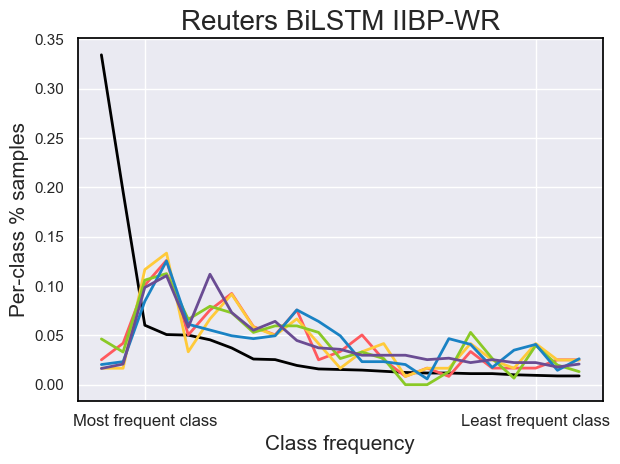

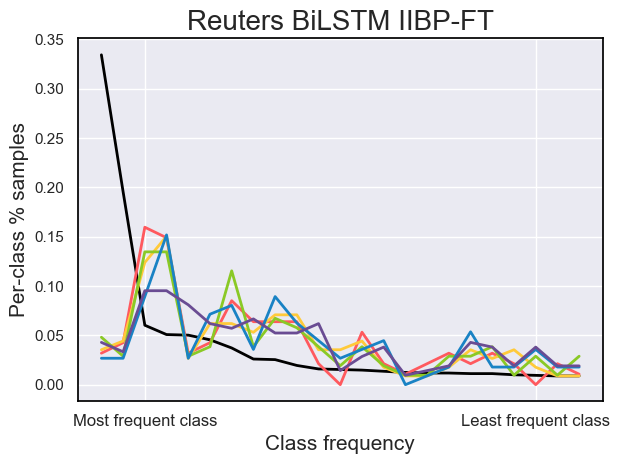

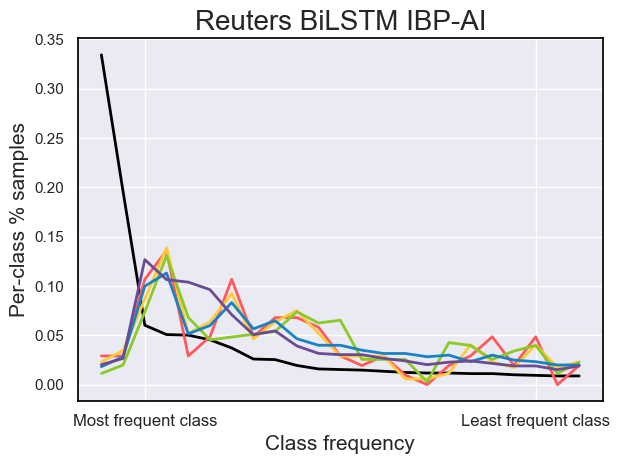

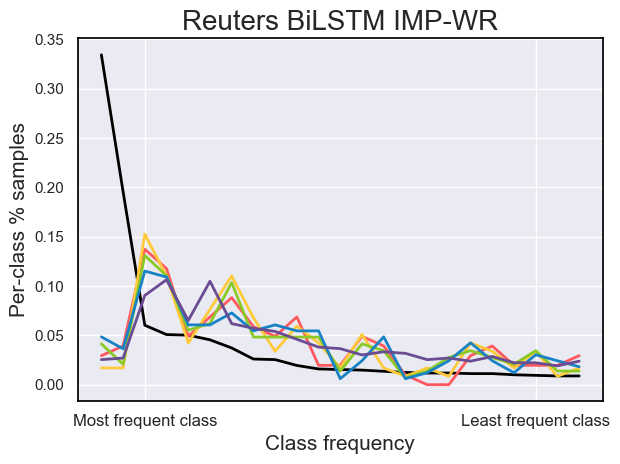

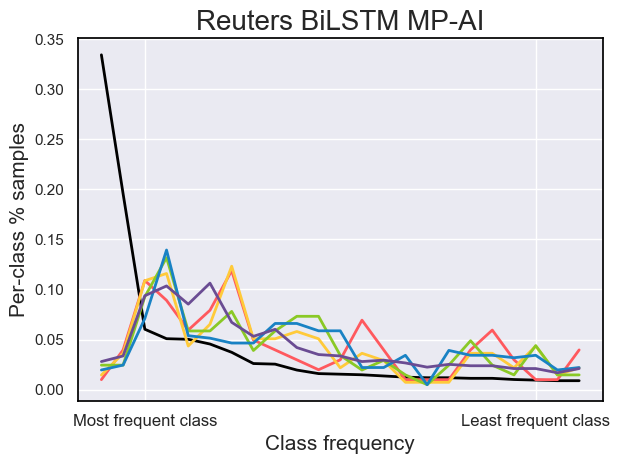

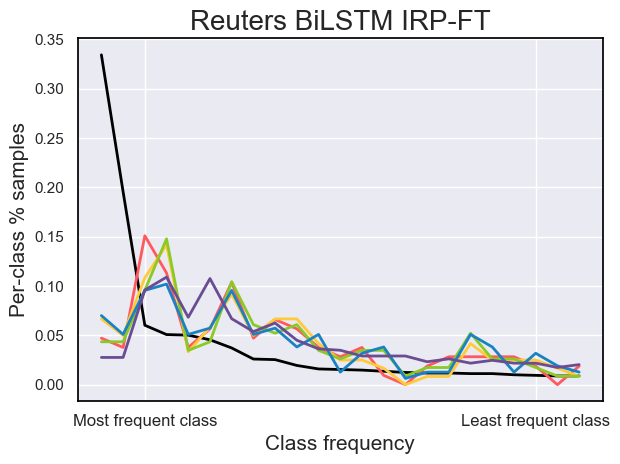

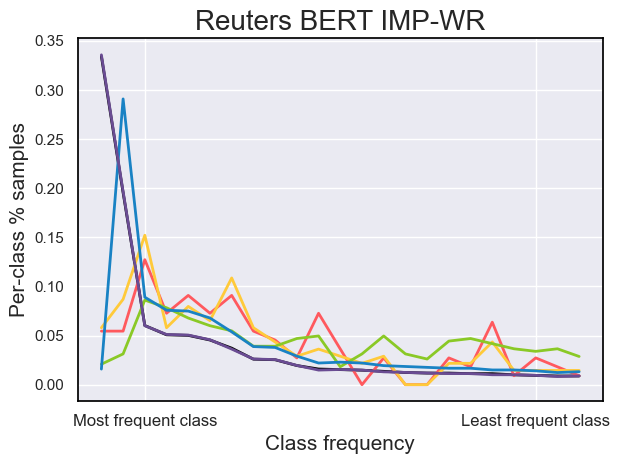

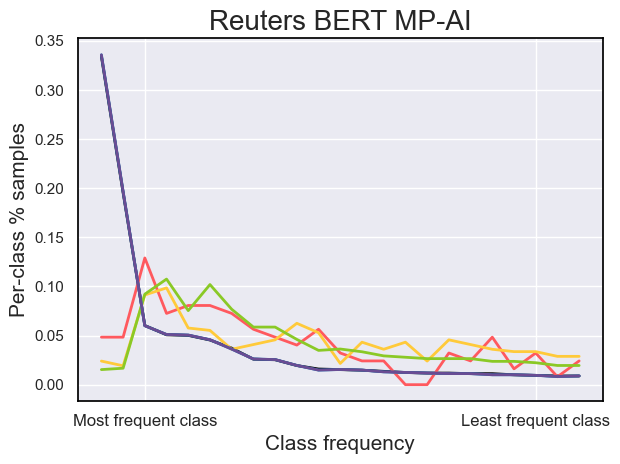

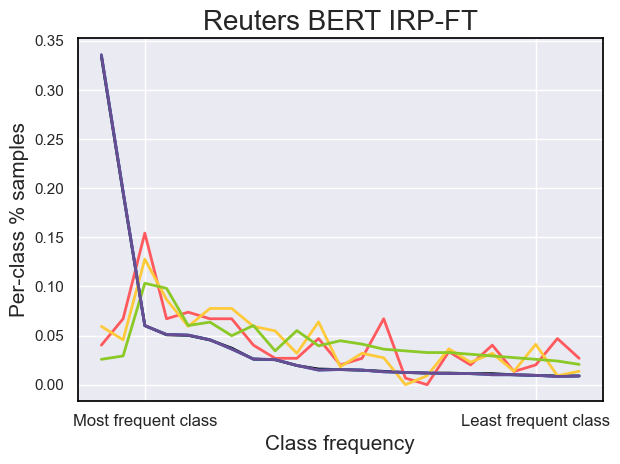

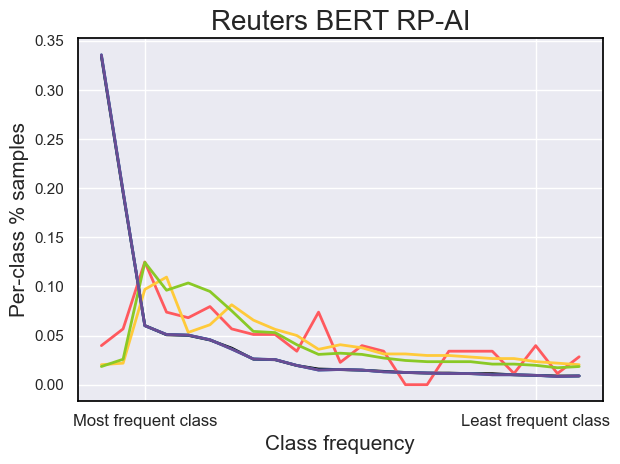

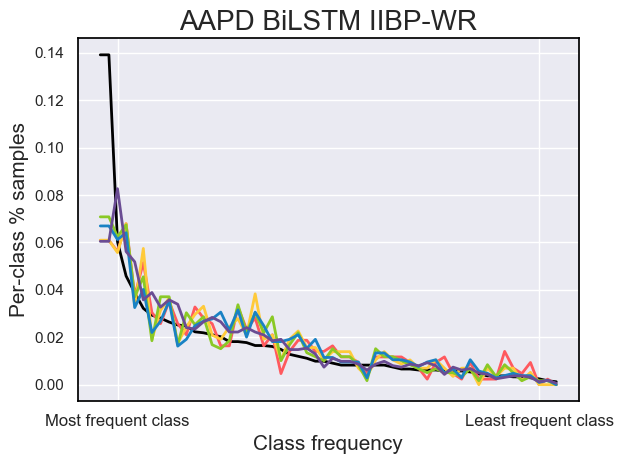

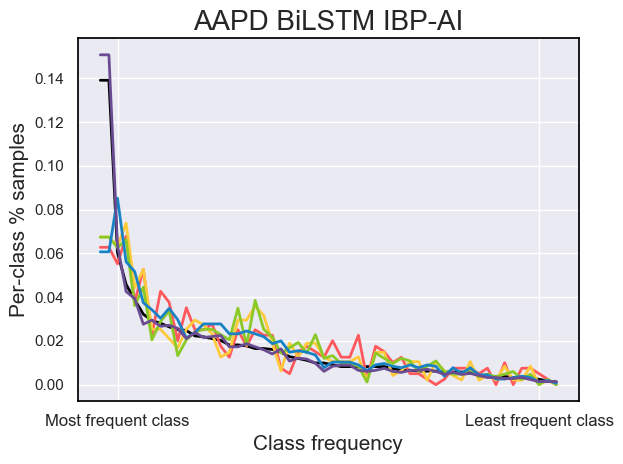

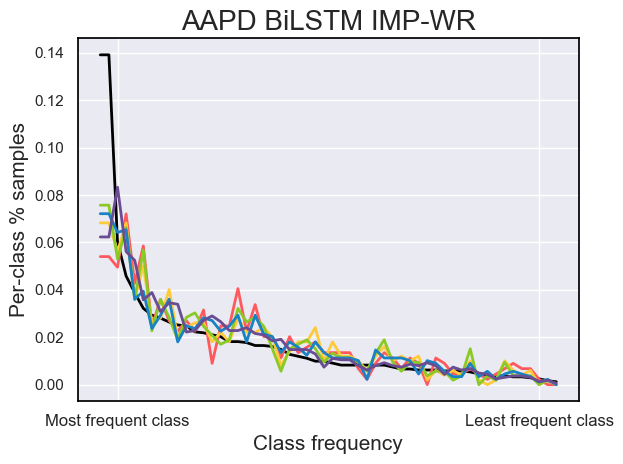

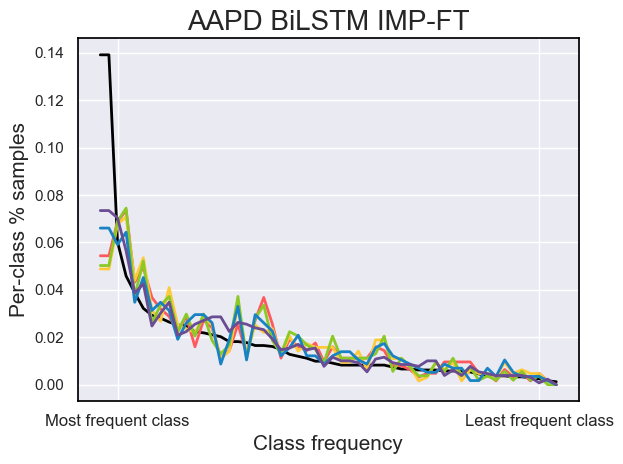

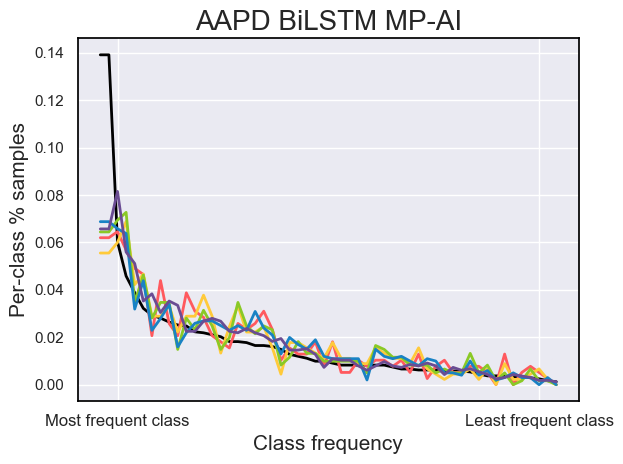

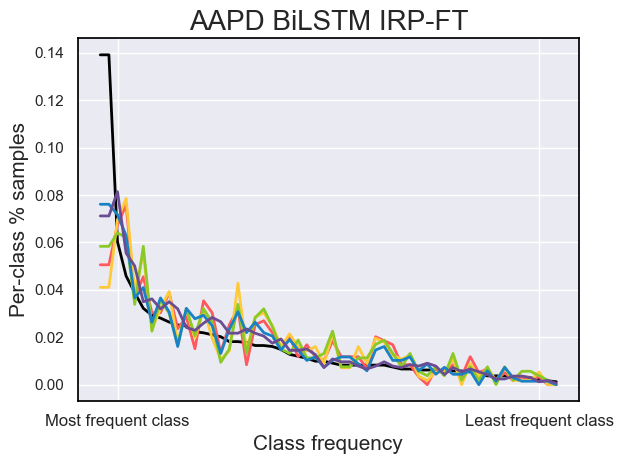

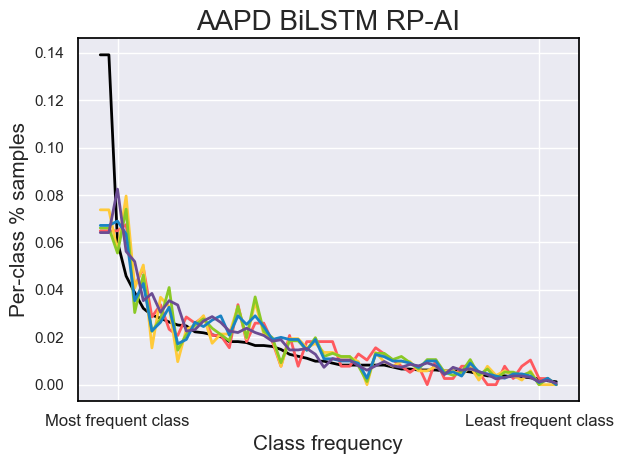

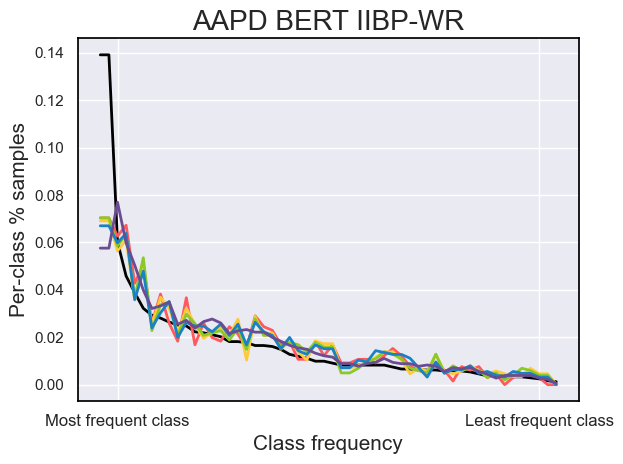

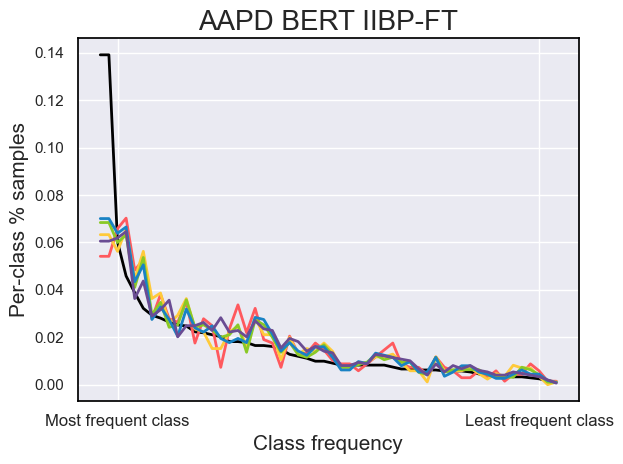

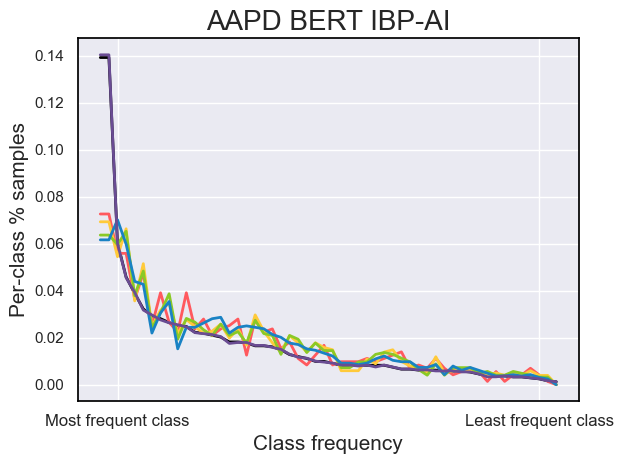

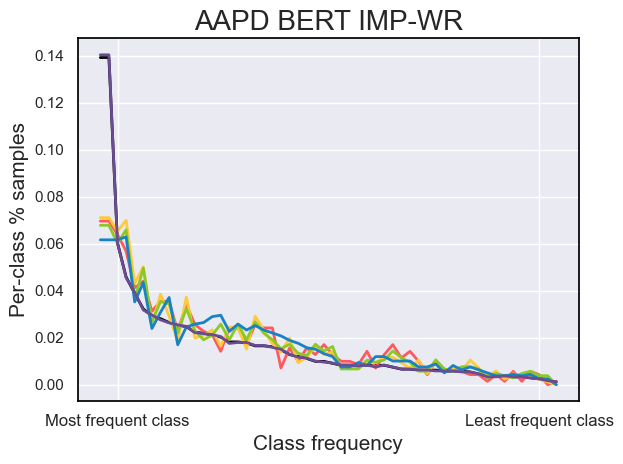

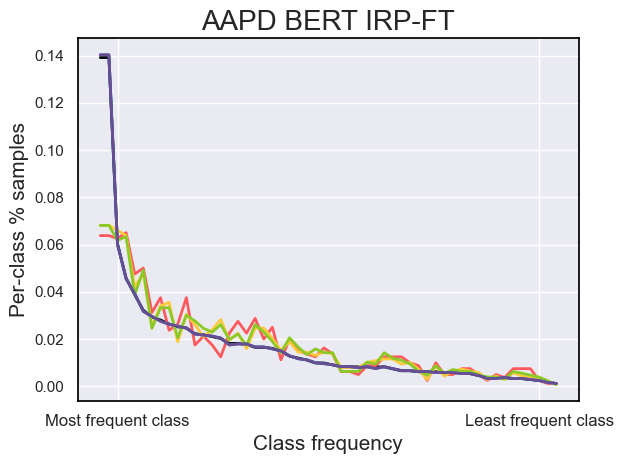

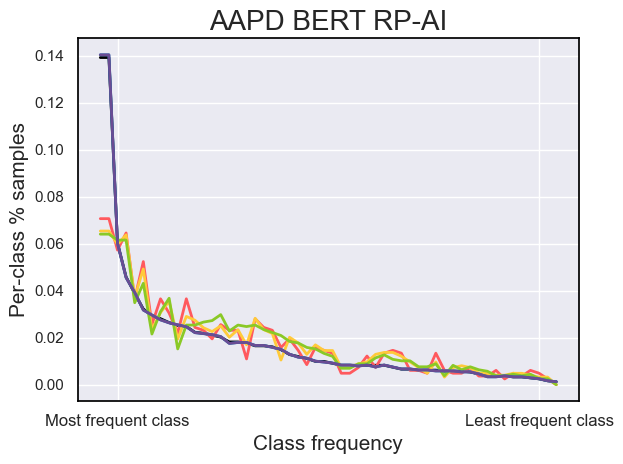

In [12]:
import matplotlib.pyplot as plt
from measures.utils import *
from measures.measures import *
import os
import seaborn as sns

names = []


old_names_to_new = {
    "IBP-WRs":"IIBP-WR",
    "IBPs":"IIBP-FT",
    "IBPs_ini":"IBP-AI",

    "IMP-WRs":"IMP-WR",
    "IMPs":"IMP-FT",
    "IMPs_ini":"MP-AI",

    "randoms":"IRP-FT",
    "randoms_ini":"RP-AI"
}


def get_images(res):

    

    colors={"0": "#000000",
        "20":'#ff595e',
        "50":'#ffca3a',
        "70":'#8ac926',
        "90":'#1982c4',
        "99":'#6a4c93'}
        
    thresholds = [20,50,70,90,99]
    for dataset in res:
        for architecture in res[dataset]:

            n = "./classes"
            if not os.path.isdir(n):
                os.makedirs(n)
        

            for algo in res[dataset][architecture]:

                #to_show = []
                legend = []

                org = {"test set":[],"PIEs 20%":[], "PIEs 50%":[], "PIEs 70%":[], "PIEs 90%":[], "PIEs 99%":[], "class":[]}
                

                dist = None

                for thres in thresholds:
                    dist = np.array(res[dataset][architecture][algo][str(thres)]["dist"])
                    dist = dist/dist.sum()
                    order = np.argsort(-dist)
                    dist = dist[order]

                    tmp = np.array(abs(res[dataset][architecture][algo][str(thres)]["pies"]))
                    tmp = tmp[order]

                    for i, v in enumerate(tmp):
                        org["PIEs 20%"].append(None)
                        org["PIEs 50%"].append(None)
                        org["PIEs 70%"].append(None)
                        org["PIEs 90%"].append(None)
                        org["PIEs 99%"].append(None)
                        org["test set"].append(dist[i])
                    
                        org["PIEs "+str(thres)+"%"][-1]=v
                        org["class"].append(i)

                    legend.append(str(thres))


                legend.append("0")

                tmp = "classes/"+dataset+"_"+architecture+"_"+algo


    
                sns.set()
                fig = plt.figure()


                #del org["PIEs 50%"]
                #del org["PIEs 70%"]
                #del org["PIEs 90%"]

                pd_tmp = pd.DataFrame(org)

                pd_tmp = pd_tmp.groupby(['class']).mean()
                pd_tmp = pd_tmp.reset_index()

                pd_tmp=pd_tmp.melt(id_vars=["class"], 
                    var_name="Distribution of", 
                    value_name="p")

                palette = sns.color_palette(["#000000", '#ff595e','#ffca3a','#8ac926','#1982c4', '#6a4c93'])
                #palette = sns.color_palette(["#000000", '#ff595e', '#6a4c93'])

                sns.lineplot(pd_tmp, x="class", y="p", hue="Distribution of", linewidth=2, palette=palette)

  

                plt.title(dataset+" "+architecture+" "+old_names_to_new[algo], fontsize=20) 

                plt.xlabel('Class frequency', fontsize=15)
                plt.ylabel('Per-class % samples', fontsize=15)

                
                ax = plt.gca()
                ax.spines['right'].set_color("black")
                ax.spines['left'].set_color("black")
                ax.spines['top'].set_color("black")
                ax.spines['bottom'].set_color("black")
                ax.get_legend().remove()


                x = np.array([2, len(dist)-3])
                my_xticks = ['Most frequent class','Least frequent class']
                plt.xticks(x, my_xticks, fontsize=12)

                plt.tight_layout()
                plt.show()

                fig.savefig("./"+tmp+".pdf", dpi=400, transparent=True)
                plt.close()


                



get_images(res)